# Übung 8 - Laminatanalyse

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def print_arr(array):
    df = pd.DataFrame(array)
    print(df)

Ziel dieser Übung ist es, gemeinsam eine Software zur Laminatanalyse zu entwickeln. Hierfür soll nach den Schritten aus der Vorlesung, bzw. dem Skript vorgegangen werden:

1. Kenngrößen der UD-Schichten bestimmen
2. Reduzierte Steifigkeit jeder Schicht bestimmen
3. Reduzierte Steifigkeit jeder Schicht in globales Koordinatensystem drehen
4. ABD-Matrix durch Integration bestimmen
5. Invertieren der ABD-Matrix
6. Deformation infolge Schnittgrößen bestimmen
7. Verzerrrung jeder Schicht bestimmen
8. Spannungen jeder Schicht bestimmen
9. Spannungen jeder Schicht in1-2-Koordinatensystem transformieren
10. Festigkeitsanalyse jeder Schicht

### 1. Laminatschichten

Fügen Sie eine Funktion hinzu, die die reduzierte Steifigkeitsmatrix 

In [5]:
class SteifigkeitsMatrix:
    """
    Klasse zur Berechnung der reduzierten Steifigkeitsmatrix für Verbundwerkstoffe.
    """
    def __init__(self, E1, E2, G12, v12):
        self.E1 = E1  # Elastizitätsmodul in Faserrichtung
        self.E2 = E2  # Elastizitätsmodul quer zur Faser
        self.G12 = G12  # Schubmodul
        self.v12 = v12  # Querkontraktionszahl
        self.v21 = E2/E1*v12

    def calculate(self):
        """
        Berechnet die reduzierte Steifigkeitsmatrix Q.
        Diese berücksichntigt den ESZ der sich in der Schicht einstellt.
        """
        self.Q11 = self.E1/(1-self.v12 * self.v21)
        self.Q22 = self.E2/(1-self.v12*self.v21)
        self.Q12 = self.v12*self.E2/(1-self.v12 * self.v21)
        self.Q66 = self.G12
        self.Q = [[self.Q11,self.Q12,0],[self.Q12,self.Q22,0],[0,0,self.Q66]]
        return self.Q

class Laminatschicht:
    """
    Klasse zur Darstellung und Analyse von Laminatschichten.
    """
    def __init__(self, t, steifigkeit, theta):
        self.t = t  # Dicke der Schicht
        self.steifigkeit = steifigkeit  # Steifigkeitsmatrix
        self.theta = theta  # Faserorientierung in Grad
    
    def reduced_steifigkeit(self):
        """
        Berechnet die reduzierte Steifigkeitsmatrix für die Laminatschicht und speichert sie in der Variable Q ab.
        """
        self.Q = self.steifigkeit.calculate()

Die unten gegebenen Materialkennwerte beschreiben die Steifigkeit von einer Unidirektionalen Einzelschicht und einem Fasergewebe.
Initalisieren Sie die entsprechenden Schichtobjekte.

In [6]:
## Unidirektionale Einzelschicht
E_1_UD = 135000. #MPa
E_2_UD = 10000. # MPa
nu_12_UD = 0.3
G_12_UD = 5000. # MPa

## Gewebe
E_1_F = 70000. # MPa
E_2_F = 70000. # MPa
nu_12_F = 0.1
G_12_F = 5000. # MPa

Geben Sie jetzt die reduzierten Steifigkeitsmatritzen aus. Nutzen Sie hierfür die oben definierte Funktion sowie die <code> print_arr </code> Funktion zum ausgeben.

In [7]:
ud_Stiffness = SteifigkeitsMatrix(E1=E_1_UD,E2=E_2_UD,v12 = nu_12_UD,G12 = G_12_UD)
print_arr(ud_Stiffness.calculate())

f_Stiffness = SteifigkeitsMatrix(E1=E_1_F,E2=E_2_F,v12 = nu_12_F,G12 = G_12_F)
print_arr(f_Stiffness.calculate())

               0             1       2
0  135906.040268   3020.134228     0.0
1    3020.134228  10067.114094     0.0
2       0.000000      0.000000  5000.0
              0             1       2
0  70707.070707   7070.707071     0.0
1   7070.707071  70707.070707     0.0
2      0.000000      0.000000  5000.0


### 2. Transformieren in das globale Koordinatensystem

Erstellen Sie eine Klasse <code>laminat</code>. Diese wird mit einer Liste von Einzelschichten initatilisert. Gehen Sie anschließend sicher, dass für jede Schicht eine reduzierte Steifigkeitsmatrix vorliegt. Schreiben sie anschließend eine Transofrmationsfunktion, die die Steifigkeiten in das globale Kooredinatensystem transformiert. Diese ist zweckmäßiger Weise teil der Klasse <code>Laminatschicht</code>.

In [16]:
class Laminat:
    """
    Klasse zur Darstellung und Analyse von Laminaten.
    """
    def __init__(self, schichten):
        """ 
        Initialisiert ein Laminat mit einer Liste von Einzelschichten.
        """
        self.schichten =schichten
        
    
    def berechne_reduzierte_steifigkeit(self):
        """
        Berechnet die Steifigkeitsmatrix des Laminats.
        """
        for schicht in self.schichten:
            schicht.reduced_steifigkeit()

    def transform_stiffness(self):
        """
        Transofrimert die reduzierten Steifigkeiten der Einzelschichten in globales Koordinatensystem
        """
        def _transformation_matrix(theta):
            theta = np.deg2rad(theta) # *2 Pi / 360
            c = np.cos(theta)
            s = np.sin(theta)
            T = [[c**2,s**2,2*c*s],[s**2,c**2,-2*c*s],[-c*s,c*s,c**2-s**2]] # (x,y,z)->(1,2,3)
            Tinv = np.linalg.inv(T) # (1,2,3)->(x,y,z)
            return Tinv

            
        for schicht in self.schichten:
            Tinv = _transformation_matrix(schicht.theta)
            
            schicht.Qbar = Tinv * schicht.Q * np.transpose(Tinv) #Qbar   =  T^-1 Q T^-1T
            
        
    def calculate_ABD_matrix(self):
        t=0
        z = [0]
        self.berechne_reduzierte_steifigkeit()
        self.transform_stiffness()
        for schicht in self.schichten:
            
            t = t+schicht.t
            z.append(schicht.t)
        z = t/2-np.array(z)

        A = np.zeros(3)
        B = np.zeros(3)
        D = np.zeros(3)
        for idx, schicht in enumerate(self.schichten):
            A = A + schicht.Qbar * (z[idx+1]-z[idx])
            B = D + schicht.Qbar * 1/2*(z[idx+1]**2-z[idx]**2)
            D = B + schicht.Qbar * 1/3*(z[idx+1]**3-z[idx]**3)


        self.A = A
        self.B = B
        self.D = D
        self.ABD = np.vstack((np.hstack((A,B)),np.hstack((B,D)))) # Ordnet die Steifigkeitesmatritzen zur ABD-Matrix an. Diese verküpft die Schnittgrößen mit der Deformation: (N,M) = ABD * (epsilon, kappa) (epsilon = Dehnung, kappa = Krümmung )

    def invert_ABD_matrix(self):
        """ 
        Invertiert die ABD-Matrix und speichert sie in der Variable ABD_inv ab.
        """        
        if self.ABD is None:
            self.calculate_ABD_matrix()
            
        self.ABD_inv = np.linalg.inv(self.ABD)
        
        
    
    

Plotten Sie anschließend die Werte der transformierten Steifigkeitsmatritzen in einem Polarplot über den Faserwinkel.

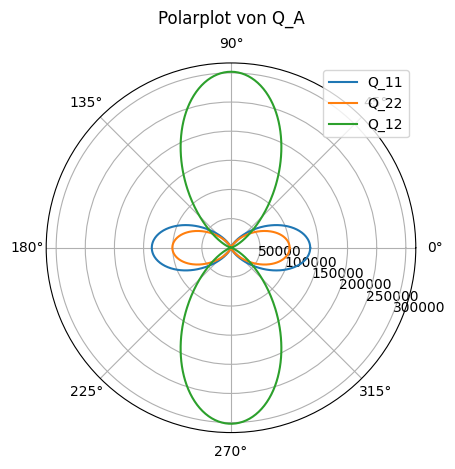

In [15]:
theta = np.arange(0,2*np.pi,0.01)
Q11, Q22, Q12 = [], [], []
for thet in theta:
    steifigkeit = SteifigkeitsMatrix(E_1_UD, E_2_UD, G_12_UD, nu_12_UD)
    schicht = Laminatschicht(0.125, steifigkeit, thet*360/2/np.pi)
    schicht.reduced_steifigkeit()
    laminat = Laminat([schicht])
    laminat.transform_stiffness()   
    Q11.append(laminat.schichten[0].Qbar[0][0])
    Q22.append(laminat.schichten[0].Qbar[1][1]*10)
    Q12.append(laminat.schichten[0].Qbar[0][1]*100)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, Q11, label='Q_11')
ax.plot(theta, Q22, label='Q_22')
ax.plot(theta, Q12, label='Q_12')
ax.legend()
ax.set_rlabel_position(-22.5)
ax.grid(True)

ax.set_title("Polarplot von Q_A", va='bottom')
plt.show()


### 3. Berechnen der ABD-Matrix eines Laminats

Fügen Sie zur Klasse <code>Laminat</code> eine Funktion zur Berechnung der ABD-Matrix hinzu. 



### 4. Invertieren der ABD-Matrix

Speichern Sie auch die invertierte ABD-MAtrix ab. Welche Funktion hat die invertierte ABD-Matrix?

### 5. Einsetzen von Beanspruchungen

Geben Sie Beanspruchungen vor. Bauen Sie vorher ein Laminat aus der vorletzten Übung nach. Können Sie das beobachtetze Verhalten in Ihren Ergebnissen wieder finden?

In [ ]:

laminat_0_0_90 = [Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,90),
                Laminatschicht(0.175,ud_Stiffness,90),
                Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,0)]

laminat_90_0_0 = [Laminatschicht(0.175,ud_Stiffness,90),
                Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,0),
                Laminatschicht(0.175,ud_Stiffness,90)]

laminat_1 = Laminat(laminat_0_0_90)
laminat_2 = Laminat(laminat_90_0_0)

laminat_1.calculate_ABD_matrix()
laminat_2.calculate_ABD_matrix()

laminat_1.invert_ABD_matrix()
laminat_2.invert_ABD_matrix()

ABD1 = laminat_1.ABD
ABD2 = laminat_2.ABD

ABD1_inv = laminat_1.ABD_inv
ABD2_inv = laminat_2.ABD_inv

loadvector = np.array([0,0,0,20,0,0]) # Loading in the form of 20 Nmm around the x-axis.
print(np.dot(ABD1_inv,loadvector ))
print(np.dot(ABD2_inv,loadvector ))

[[-2.11127561e-61 -3.33740562e+02  0.00000000e+00]
 [-3.33740562e+02 -1.56390786e-62  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.52526042e+02]]
[ 0.00228174  0.          0.         -0.00361345  0.          0.        ]
[-4.81150870e-66  1.02678403e-01  0.00000000e+00  7.61967726e-66
 -1.62605191e-01  0.00000000e+00]
